Example Notebook
============

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
basedir = '../'
sys.path.append(basedir)

from lda_for_fragments import Ms2Lda
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import sys
import visualisation.pyLDAvis as pyLDAvis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Number of topics, around 300-400 seems to be good for the beer/urine data from cross-validation results
n_topics = 200 

# How many samples to get during Gibbs sampling, recommended >500 for analysis
n_samples = 40

# No. of burn-in samples to discard before we start averaging over the samples. 
# If 0, then we'll use only the last sample for the results.
n_burn = 0 

# Thinning parameter when averaging over the samples. 
# If n_burn is 0 then this doesn't matter.
n_thin = 1 

# Follow the recommendation from Griffith & Styver
alpha = 50.0/n_topics # hyper-parameter for document-topic distributions
beta = 0.1 # hyper-parameter for topic-word distributions

fragment_filename = basedir + 'input/relative_intensities/Beer_3_T10_POS_fragments_rel.csv'
neutral_loss_filename = basedir + 'input/relative_intensities/Beer_3_T10_POS_losses_rel.csv'
mzdiff_filename = None

ms1_filename = basedir + 'input/relative_intensities/Beer_3_T10_POS_ms1_rel.csv'
ms2_filename = basedir + 'input/relative_intensities/Beer_3_T10_POS_ms2_rel.csv'

In [4]:
ms2lda = Ms2Lda.lcms_data_from_R(fragment_filename, neutral_loss_filename, mzdiff_filename, 
                                 ms1_filename, ms2_filename)

Data shape (856, 1664)


In [5]:
ms2lda.run_lda(n_topics, n_samples, n_burn, n_thin, alpha, beta)

Fitting model...
CGS LDA initialising
......................................................................................
Using Numba for LDA sampling
Preparing words
Preparing Z matrix
DONE
Sample 1   Log joint likelihood = -3339009.110 
Sample 2   Log joint likelihood = -2325794.021 
Sample 3   Log joint likelihood = -1681305.154 
Sample 4   Log joint likelihood = -1451756.585 
Sample 5   Log joint likelihood = -1364194.502 
Sample 6   Log joint likelihood = -1319632.704 
Sample 7   Log joint likelihood = -1290730.762 
Sample 8   Log joint likelihood = -1271272.558 
Sample 9   Log joint likelihood = -1255198.485 
Sample 10   Log joint likelihood = -1242500.707 
Sample 11   Log joint likelihood = -1232448.306 
Sample 12   Log joint likelihood = -1224695.580 
Sample 13   Log joint likelihood = -1217878.171 
Sample 14   Log joint likelihood = -1211467.443 
Sample 15   Log joint likelihood = -1206626.787 
Sample 16   Log joint likelihood = -1201350.354 
Sample 17   Log joint likelihoo

In [6]:
ms2lda.write_results('beer3_pos_rel')

Writing topics to results/beer3_pos_rel/beer3_pos_rel_topics.csv
Writing fragments x topics to results/beer3_pos_rel/beer3_pos_rel_all.csv
Writing topic docs to results/beer3_pos_rel/beer3_pos_rel_docs.csv


In [7]:
ms2lda.print_topic_words()

Topic 0: loss_115.02685 (0.115361685215), loss_64.01556 (0.0994634340223), fragment_202.09773 (0.0994634340223), fragment_184.07218 (0.0994634340223), loss_170.06921 (0.0736287758347), fragment_95.06076 (0.0587241653418), loss_171.0529 (0.0587241653418), fragment_96.04414 (0.0577305246423),
Topic 1: fragment_98.98387 (0.534253432494), loss_120.04178 (0.143807208238), fragment_211.10574 (0.134510869565),
Topic 2: fragment_276.14368 (0.337238705327), fragment_230.14 (0.112188132165), loss_64.01556 (0.0953304113284), fragment_132.10161 (0.075101146325),
Topic 3: loss_105.07856 (0.172042188933), fragment_107.06036 (0.152170590034), loss_132.0896 (0.104020177316), fragment_134.07171 (0.0765056557628), fragment_80.04949 (0.0528125955365), loss_59.07329 (0.0505197187404),
Topic 4: fragment_76.03917 (0.17517210416), loss_123.05299 (0.141499551033), fragment_202.07071 (0.135513319365), fragment_258.13332 (0.0786441185274),
Topic 5: loss_45.05793 (0.368920363442), fragment_105.11003 (0.133752004

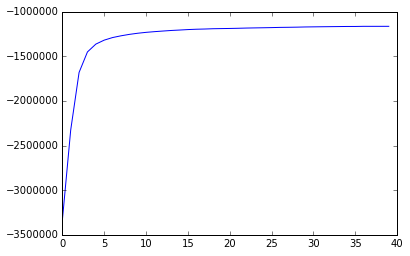

In [8]:
ms2lda.plot_log_likelihood()

2. Shared Fragments within a Topic
--------------------------------------

If the 'interactive' parameter below is True, we will show an interactive visualisation of the results in a separate tab. You need to interrupt the kernel to stop it once you're done with it (from the menu above, Kernel > Interrupt).

In [ ]:
ms2lda.plot_lda_fragments(consistency=0.50, sort_by="h_index", interactive=True)
# ms2lda.plot_lda_fragments(consistency=0.50, sort_by="in_degree")

Ranking topics ...
Topic 8 h-index=6
Topic 8 has 8 ms1 peaks
Topic 18 h-index=6
Topic 18 has 13 ms1 peaks
Topic 58 h-index=5
Topic 58 has 12 ms1 peaks
Topic 59 h-index=5
Topic 59 has 7 ms1 peaks
Topic 87 h-index=5
Topic 87 has 16 ms1 peaks
Topic 91 h-index=5
Topic 91 has 9 ms1 peaks
Topic 99 h-index=5
Topic 99 has 15 ms1 peaks
Topic 112 h-index=5
Topic 112 has 13 ms1 peaks
Topic 121 h-index=5
Topic 121 has 11 ms1 peaks
Topic 191 h-index=5
Topic 191 has 7 ms1 peaks
Topic 192 h-index=5
Topic 192 has 19 ms1 peaks
Topic 27 h-index=4
Topic 27 has 12 ms1 peaks
Topic 31 h-index=4
Topic 31 has 7 ms1 peaks
Topic 105 h-index=4
Topic 105 has 9 ms1 peaks
Topic 114 h-index=4
Topic 114 has 15 ms1 peaks
Topic 123 h-index=4
Topic 123 has 10 ms1 peaks
Topic 132 h-index=4
Topic 132 has 7 ms1 peaks
Topic 134 h-index=4
Topic 134 has 9 ms1 peaks
Topic 145 h-index=4
Topic 145 has 12 ms1 peaks
Topic 154 h-index=4
Topic 154 has 9 ms1 peaks
Topic 170 h-index=4
Topic 170 has 19 ms1 peaks
Topic 171 h-index=4
Top